# Application of Gibbs Sampling to Mixture of Gaussians

## Task
The file `data_ex06.csv` contains data sampled from a mixture of $K = 4$ Gaussians. The standard deviations of the Gaussians are known and
identical, $\sigma_k = \sigma = 0.5$. Reconstruct the unknown parameters and the latent variables:
$$
    p_k, \mu_k, Z_i
$$
where $Z_i$ represents the assignment of each point to one of the mixture components. To perform the inference, use _Gibbs sampling_.


## Gibbs sampling
**Step 1** <br>
Initialize randomly $p_k, \mu_k, Z_i$. Compute $N_k = \sum_i \chi(Z_i=k)$ and $m_k=\sum_i \chi(Z_i=k) x_k$.

**Step 2** <br>
Perform Gibbs sampling iterations:
- Sample $\mu_k$ for all $k$ from a normal with mean:
  $$
    \mu'_k = \left(\frac{\mu_0}{\sigma_0^2}+\frac{m_k}{\sigma^2}\right)\frac{1}{\left(\frac{1}{\sigma_0^2}+\frac{N_k}{\sigma^2}\right)}
  $$
  and standard deviation:
  $$
    \sigma'_k = \left(\frac{1}{\sigma_0^2}+\frac{N_k}{\sigma^2}\right)^{-\frac{1}{2}}
  $$
  Here $\mu_0 = 0$ and $\sigma_0 = 1000$ are the Gaussian prior parameters. Do this for all $k$.

- Sample the $\vec{p}$ from a Dirichlet distribution with parameters $\gamma'_k=\gamma_k+N_k$. Here $\gamma_k=1$ are the Dirichlet prior parameters.

- Sample the $Z_i$ from a categorical distribution:
  $$
    P(Z_i=k) = \frac{p_k\exp\left\{-\frac{(x_i-\mu_k)^2}{2\sigma^2}\right\}}{\sum_k p_k\exp\left\{-\frac{(x_i-\mu_k)^2}{2\sigma^2}\right\}}
  $$

- If $Z_i$ is updated, update $N_k$ and $m_k$, and consequentially $\vec{\mu}', \vec{\sigma}', \vec{\gamma}', \vec{p}'$.

## Mixture of Gaussians (MoG)
Assume to have $N$ 1-dimensional points generated from a Mixture of $D$ Gaussians with parameters $\mu_i, \sigma_i$ for $i=1, \dots, N$. Then, assuming i.i.d. points, the likelihood function can be written as:
$$
  f\left(\vec{x}|\vec{p}, \vec{\mu}, \vec{\sigma}\right) = \prod_{i=1}^N f\left(x_i|\vec{p}, \vec{\mu}, \vec{\sigma}\right) =  
  \prod_{i=1}^N \sum_{k=1}^D p_k \mathcal{N}(x_i|\mu_k, \sigma_k^2)
$$
Given the likelihood, the posterior becomes:
$$
  f\left(\vec{p}, \vec{\mu}, \vec{\sigma}|\vec{x}\right) = \left(\prod_{i=1}^N \sum_{k=1}^D p_k \mathcal{N}(x_i|\mu_k, \sigma_k^2)\right) \times f_{prior}(\vec{p}, \vec{\mu}, \vec{\sigma})
$$

The problem with respect to Metropolis is that the order of operations involved in the computation of the likelihood is $\mathcal{O}(DN)$, which is computationally heavy and makes the problem intractable. 

A strategy to simplify the problem and make the inference task more interesting is to write the generative process in a slightly different form, i.e. as the combination of 2 random processes:
1. extract $Z_i\in\{1, \dots, D\}$ with probability $\{p_1, \dots, p_D\}$
2. extract $x_i$ from the corresponding component of the mixture: $\mathcal{N}(\mu_i, \sigma_i^2)$

The variables $Z_i$ are called _latent variables_ and are unknown. They represent the mixture component from which each point $x_i$ was sampled. Thus, they are distributed according to a categorical distribution:
$$
  Z_i\sim Cat(\vec{p}) \quad \text{i.e.} \quad P(Z_i=k)=p_k
$$
Then the likelihood becomes:
$$
  f\left(x_i|\vec{\mu}, \vec{\sigma}, Z_i\right) = \mathcal{N}(\mu_{Z_i}, \sigma_{Z_i}^2) \iff f\left(x_i|\vec{\mu}, \vec{\sigma}, Z_i=k\right) = \mathcal{N}(\mu_k, \sigma_k^2)
$$
meaning that when $Z_i = k$,  $x_i$ is sampled from a Gaussian with mean $\mu_k$ and variance $\sigma^2$. 

We can also rewrite the posterior using the latent variables:
$$
\begin{align*}
  f\left(\vec{x}|\vec{\mu}, \vec{\sigma}, \vec{Z}\right) &= \prod_{i=1}^N f\left(x_i|\vec{\mu}, \vec{\sigma}, Z_i\right) = \\
  &= \prod_{i=1}^N \mathcal{N}(x_i|\mu_{Z_i}, \sigma_{Z_i}^2) = \\
  &= \prod_{i=1}^N \left(2\pi\sigma_{Z_i}^2\right)^{-\frac{1}{2}} e^{-\frac{1}{2}\frac{(x_i-\mu_{Z_i})^2}{\sigma_{Z_i}^2}} = \\
  &= \prod_{k=1}^D \left(2\pi\sigma_{Z_i}^2\right)^{-\frac{N_k}{2}} e^{-\frac{1}{2}\sum_{i=1}^N \chi(Z_i=k)\frac{(x_i-\mu_k)^2}{\sigma_{k}^2}}
\end{align*}
$$
where $\chi(Z_i=k)=1$ if $x_i$ is such that $Z_i=k$, else $0$. Here $N_k = \sum_i \chi(Z_i=k)$.

Notice that the model with latent variables $Z_i$ allows to:
1. Drastically reduce the computational complexity of computing the likelihood
2. Use conjugate priors, which considerably simplifies the shape of the posterior, enabling Gibbs sampling
   
At this point we can infer all the parameters from the data, assuming for simplicity that $\sigma_k=\sigma=0.5 \, \forall k$. 

### Priors
- The prior of $\mu_k$ is Gaussian with parameters $\mu_0$, $\sigma_0$: 
  $$ 
    \mu_k|\mu_0, \sigma_0 \sim \mathcal{N}(\mu_0, \sigma_0^2)
  $$
  Then:
  $$ 
    f_{prior}(\vec{\mu}|\mu_0, \sigma_0^2)=\prod_{k=1}^D f_{prior}(\mu_k|\mu_0, \sigma_0^2) = (2\pi\sigma_{0})^{-\frac{D}{2}}\prod_{k=1}^D e^{-\frac{(\mu_0-\mu_k)^2}{2\sigma_0^2}}
  $$

- For $\vec{p}$ we may assume a Dirichlet prior, which is the generalization of a Beta, i.e. the conjugate prior for Bernoulli trials:
  $$
    p_{k}|\vec{\gamma}\sim Dir(\vec{\gamma})
  $$ 
  or 
  $$
    f_{prior}(\vec{p}|\vec{\gamma})=(\beta(\vec{\gamma}))^{-1}\prod_{k=1}^D p_{k}^{\gamma_{k}-1}
  $$
  This is the conjugate prior for the multinomial distribution. We can fix the hyperparameters to have a non-informative prior $\gamma_{k}=1$
  (uniform prior). 

- From the assumptions, we know that 
  $$
    f_{prior}(Z_i=k|p_k)=p_k \quad \Longrightarrow \quad f_{prior}(\vec{Z}|\vec{p}) = \prod_{k=1}^D p_k^{N_k} 
  $$

### Posterior
The posterior simply becomes:
$$
f(\vec{\mu},\vec{Z},\vec{p}|\vec{x})= \frac{1}{E(\vec{x})}\times f_{likelihood}(\vec{x}|\vec{\mu},\sigma, \vec{Z})\times f_{prior}(\vec{\mu}|\mu_{0}, \sigma_{0})\times f_{prior}(\vec{Z}|\vec{p})\times f_{prior}(\vec{p}|\vec{\gamma})
$$
where $E(\vec{x})$ is the evidence. 

### Conditional posteriors
We want to sample the above posterior using Gibbs Sampling. To do so, we need to compute the conditional distributions:
$$
\begin{align*}
  f&(\mu_k | \vec{\mu}_{-k},\vec{Z},\vec{p}, \vec{x}) \\
  f&(p_k | \vec{\mu},\vec{Z},\vec{p}_{-k}, \vec{x}) \\
  f&(Z_i | \vec{\mu},\vec{Z}_{-i},\vec{p}, \vec{x}) 
\end{align*}
$$
Even if it looks very difficult, in the computation most terms cancel out. The computation is done using Bayes theorem and marginalization; for semplicity we report here only the final results. 

For $\mu_k$:
$$
  \mu_{k}|\vec{\mu}_{-k},\vec{Z},\vec{p}, \vec{x}\sim \mathcal{N}(\mu_k', \sigma_k'^2)
$$
with
$$
\begin{align*}
  \mu'_k &= \left(\frac{\mu_0}{\sigma_0^2}+\frac{m_k}{\sigma^2}\right)\frac{1}{\left(\frac{1}{\sigma_0^2}+\frac{N_k}{\sigma^2}\right)} \\
  \sigma'_k &= \left(\frac{1}{\sigma_0^2}+\frac{N_k}{\sigma^2}\right)^{-\frac{1}{2}}
\end{align*}  
$$

For $p_k$:
$$
  \vec{p}|\vec{\mu},\vec{Z},\vec{p}_{-k}, \vec{x}\sim Dir(\vec{\gamma'}) 
$$
with
$$
  \vec{\gamma'}=\vec{\gamma}+\vec{N}
$$

Finally, for $Z_i$:
$$
  Z_{i}|\vec{\mu},\vec{Z}_{-i},\vec{p}, \vec{x} \sim Cat(\vec{p'})
$$
with
$$
  {p'}_k \propto p_k e^{-\frac{(x_{i}-\mu_{k})^{2}}{2\sigma^{2}}}
$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm

data = pd.read_csv('./data/data_ex06.csv', header=None).values.flatten()
print('There are %i data points' %len(data))

sigma = 0.5
K = 4

There are 1000 data points


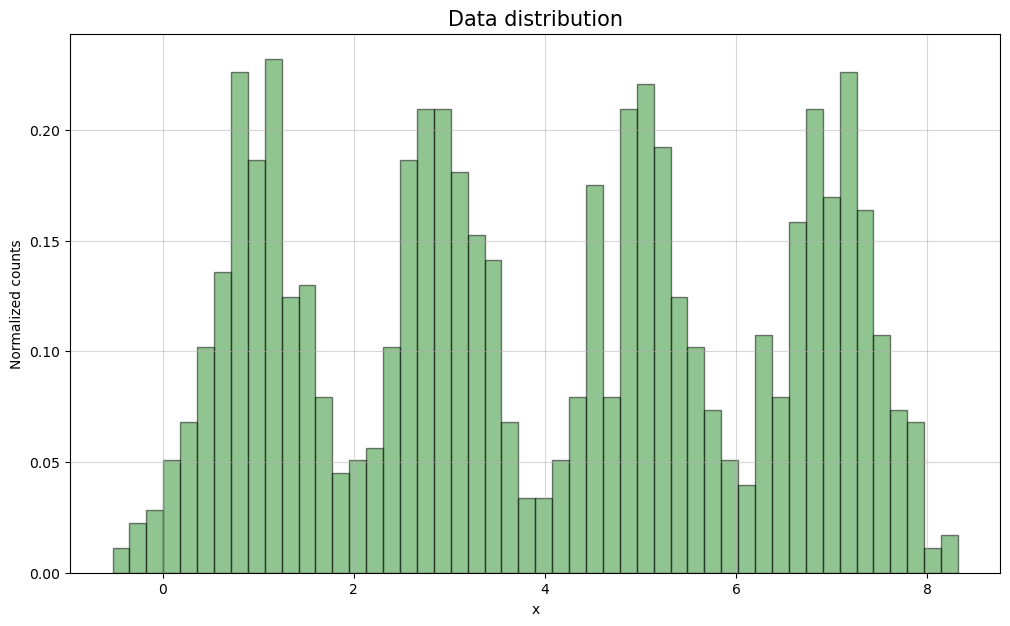

In [2]:
# plot data distribution 
fig, ax = plt.subplots(figsize=(12, 7))

hist_val_div = ax.hist(data, bins=50, edgecolor='black', alpha=0.5, density=True, color='forestgreen')

ax.set_xlabel('x', fontsize=10)
ax.set_ylabel('Normalized counts', fontsize=10)
ax.grid(alpha=0.5)
ax.set_title('Data distribution', fontsize=15)

plt.show()

## Define Gibbs Sampling steps
Notice that $Z_i\in \{0, 1, 2, 3\}$.

In [3]:
def gen_N_vec(Z_vec):
    tmp = np.zeros(K)
    for i in range(K):
        tmp[i] = np.sum(Z_vec==i)
        
    return tmp
    
def gen_m_vec(Z_vec, x=data):
    tmp = np.zeros(K)
    for i in range(K):
        tmp[i] = np.sum(x[Z_vec==i])
        
    return tmp

def sample_mu_vec(N_vec, m_vec, mu_0=0, sg_0=1000):
    mu_vec = np.zeros(K)
    
    for k in range(K):
        N_k, m_k = N_vec[k], m_vec[k]
        
        mu_prime = (mu_0/sg_0**2+m_k/sigma**2)/(1/sg_0**2+N_k/sigma**2)
        sg_prime = (1/sg_0**2+N_k/sigma**2)**(-0.5)
    
        mu_vec[k] = np.random.normal(loc=mu_prime, scale=sg_prime)
    
    return mu_vec

def sample_p_vec(N_vec, gamma_vec=np.ones(K)):
    gamma_prime = gamma_vec + N_vec
    p_vec = np.random.dirichlet(gamma_prime)
    return p_vec

def sample_Z_vec(mu_vec, p_vec, x=data): 
    Z_vec = np.zeros(len(x))
    
    for i, x_i in enumerate(x):
        p_vec_prime = p_vec*np.exp(-(x_i-mu_vec)**2/(2*sigma**2))
        p_vec_prime /= np.sum(p_vec_prime)
        
        Z_vec[i] = np.random.choice(a=np.arange(K), p=p_vec_prime)  
        
    return Z_vec  

## Gibbs Sampling function and inference task

In [4]:
def Gibbs_Sampling_for_MoG(mu0, p0, Z0, n_samples, burn_in=0, x=data):
    mu_vec_curr = mu0
    p_vec_curr = p0
    Z_vec_curr = Z0
    
    # initialize the chain object
    f_sampled = {'mu': np.zeros((K, n_samples)), 'p': np.zeros((K, n_samples)), 'Z': np.zeros((len(x), n_samples))}

    # initialize N and m
    N_vec_curr = gen_N_vec(Z_vec_curr)
    m_vec_curr = gen_m_vec(Z_vec_curr)
    
    # MCMC algorithm
    i = 0
    while i<(burn_in + n_samples):
        if i%100 == 0:
            print('Iteration %i ...' %i)
            
        # step 1: sample mu
        mu_vec_curr = sample_mu_vec(N_vec_curr, m_vec_curr)
        
        # step 2: sample p
        p_vec_curr = sample_p_vec(N_vec_curr)
        
        # step 2: sample Z
        Z_vec_new = sample_Z_vec(mu_vec_curr, p_vec_curr)
        
        # step 3: if Z is updated, update N and m
        if not np.array_equal(Z_vec_new, Z_vec_curr):
            Z_vec_curr = Z_vec_new
            N_vec_curr = gen_N_vec(Z_vec_curr)
            m_vec_curr = gen_m_vec(Z_vec_curr)
        
        # store chain
        if i >= burn_in:
            f_sampled['mu'][:, i-burn_in] = mu_vec_curr
            f_sampled['p'][:, i-burn_in] = p_vec_curr
            f_sampled['Z'][:, i-burn_in] = Z_vec_curr
            
        i+=1
    
    print('Iteration %i reached!' %(burn_in + n_samples))
    
    return f_sampled
    

In [5]:
# initialize randomly p, mu, Z
np.random.seed(1234)

mu0 = 8*np.random.uniform(size=K)
p0 = np.random.dirichlet(np.ones(K))
Z0 = np.random.choice(np.arange(K), size=len(data))

burn_in = 0
n_steps = 500

print('Initial state:')
print('u = ', np.round(mu0, 3))
print('p = ', np.round(p0, 3))
print('Z = \n', Z0)


Initial state:
u =  [1.532 4.977 3.502 6.283]
p =  [0.401 0.084 0.086 0.429]
Z = 
 [0 0 2 2 2 0 0 0 1 0 1 3 2 2 3 2 0 3 0 1 2 2 2 3 3 3 0 1 3 0 3 2 3 0 1 3 3
 3 2 1 2 3 3 0 2 3 2 0 1 3 1 0 0 0 1 1 1 3 1 3 1 0 1 0 1 0 1 0 0 0 2 0 2 0
 2 3 3 1 2 1 2 2 1 1 2 3 0 3 1 2 3 2 0 2 3 3 2 2 0 0 2 3 1 3 3 2 3 2 1 2 3
 0 1 0 1 2 1 2 1 2 1 1 1 3 0 3 3 1 2 0 0 1 0 1 2 1 1 2 3 2 0 1 1 1 3 2 0 0
 3 0 0 2 0 0 0 0 1 0 2 1 3 0 2 0 3 2 2 3 3 2 2 1 3 0 0 1 1 2 2 3 1 0 3 2 0
 1 1 1 0 0 1 3 3 0 0 0 1 1 0 2 3 1 1 2 1 3 3 3 1 3 0 0 1 0 1 3 2 1 1 2 2 2
 1 0 3 0 0 0 0 0 3 3 1 1 1 2 1 3 1 3 0 3 3 1 3 3 2 3 1 2 3 2 2 0 2 1 1 3 3
 3 0 3 2 0 2 1 3 3 2 0 1 1 3 2 0 3 0 2 3 1 3 1 3 0 3 1 0 0 1 2 2 3 1 0 3 1
 0 1 1 0 2 3 1 2 3 1 0 3 3 3 0 2 2 1 3 3 0 1 3 0 0 0 3 0 2 1 3 0 2 0 1 1 1
 0 3 1 0 1 2 1 1 2 3 1 1 0 2 1 2 1 1 3 3 1 1 1 0 0 0 2 1 3 0 3 1 2 2 3 2 1
 1 0 0 2 3 3 1 3 3 2 0 0 2 2 1 2 1 0 2 3 2 3 2 0 3 0 2 0 2 0 0 3 1 2 0 0 3
 3 2 3 0 2 0 2 1 1 0 0 0 1 0 3 2 3 1 3 1 0 1 1 1 2 2 3 0 1 2 3 1 0 3 1 2 2
 2 0 3 3 3 1 0 1 

In [6]:
chains_evol = Gibbs_Sampling_for_MoG(mu0, p0, Z0, n_samples=n_steps, burn_in=burn_in)

Iteration 0 ...
Iteration 100 ...
Iteration 200 ...
Iteration 300 ...
Iteration 400 ...
Iteration 500 reached!


## Chain analysis

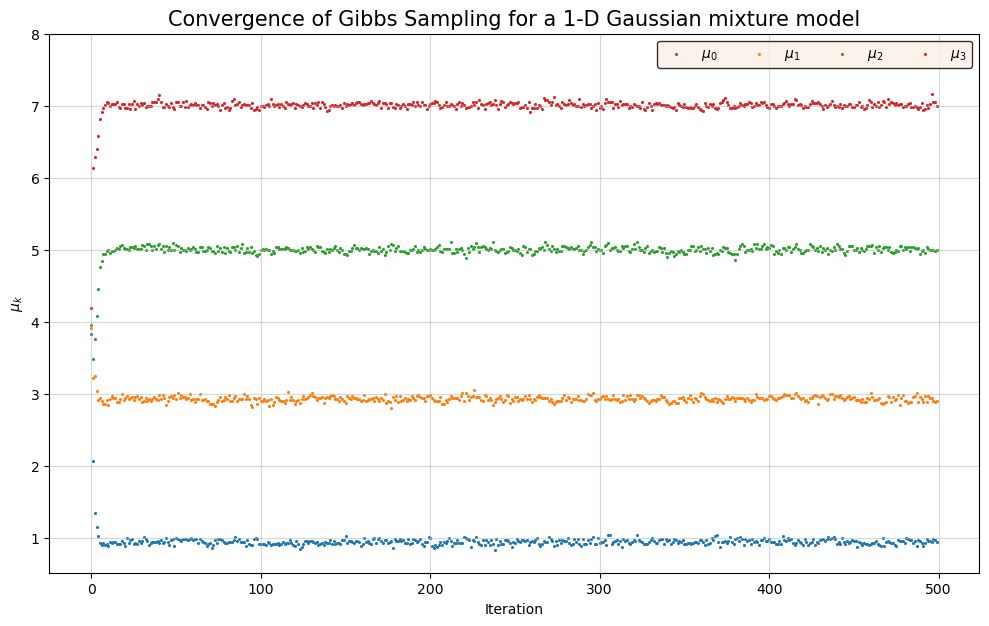

In [7]:
fig, ax = plt.subplots(figsize=(12, 7))
    
for i in range(K):
    ax.scatter(range(0, n_steps), chains_evol['mu'][i, :], s=1.5, label='$\mu_%i$' %i)
    
ax.grid(alpha=0.5)
ax.legend(edgecolor='black', facecolor='linen', fontsize=10, loc='upper right', ncol=4)
ax.set_ylim(top=8)

ax.set_xlabel('Iteration', fontsize=10)
ax.set_ylabel('$\mu_k$', fontsize=10)
ax.set_title('Convergence of Gibbs Sampling for a 1-D Gaussian mixture model', fontsize=15)
    
plt.show()

In [8]:
burn_in_after = 20

mu_k_mean = np.mean(chains_evol['mu'][:, burn_in_after:], axis=1)
mu_k_std  =  np.std(chains_evol['mu'][:, burn_in_after:], axis=1)
p_k_mean = np.mean(chains_evol['p'][:, burn_in_after:], axis=1)
p_k_std  =  np.std(chains_evol['p'][:, burn_in_after:], axis=1)

print('Estimated values of u:')
for i in range(K):
    print(' u_%i = %.3f +- %.5f' %(i, mu_k_mean[i], mu_k_std[i]))
   
print('\nEstimated values of p:') 
for i in range(K):
    print(' p_%i = %.3f +- %.5f' %(i, p_k_mean[i], p_k_std[i]))

Estimated values of u:
 u_0 = 0.947 +- 0.03418
 u_1 = 2.933 +- 0.03706
 u_2 = 5.007 +- 0.03820
 u_3 = 7.012 +- 0.03489

Estimated values of p:
 p_0 = 0.255 +- 0.01462
 p_1 = 0.248 +- 0.01514
 p_2 = 0.242 +- 0.01389
 p_3 = 0.255 +- 0.01381


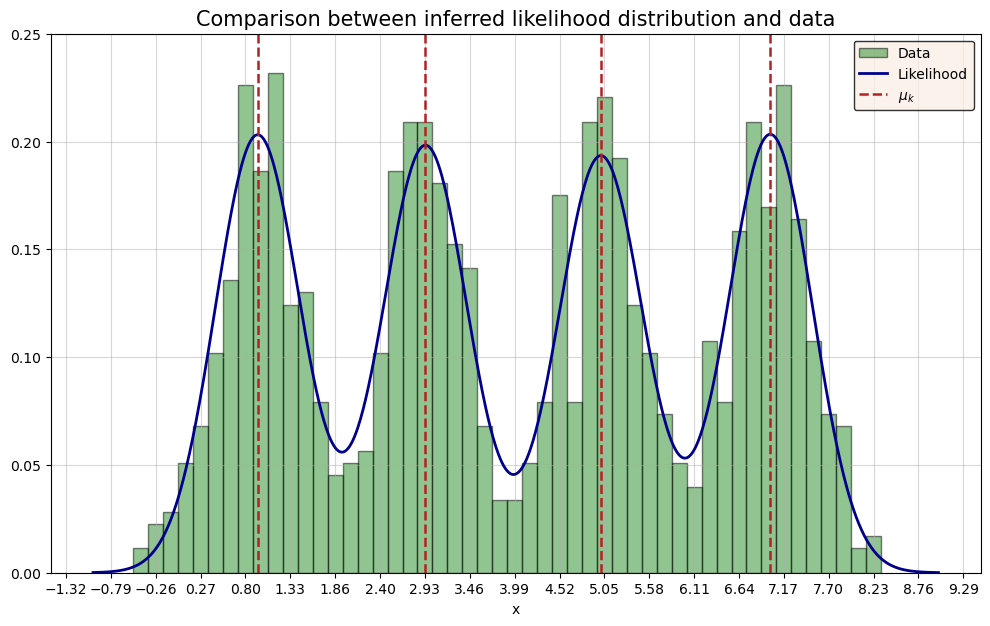

In [9]:
def MoG(x, p_vec, mu_vec):
    f_x = np.zeros(len(x))
    
    for p_k, mu_k in zip(p_vec, mu_vec):
        f_x += p_k*norm.pdf(x, loc=mu_k, scale=sigma)
        
    return f_x


fig, ax = plt.subplots(figsize=(12, 7))

hist_n, hist_bins, _ = ax.hist(data, bins=50, edgecolor='black', alpha=0.5, density=True, color='forestgreen', label='Data')

x_plot = np.linspace(-1, 9, 1000)
ax.plot(x_plot, MoG(x_plot, p_k_mean, mu_k_mean), color='darkblue', linewidth=2, label='Likelihood')

ax.set_xlabel('x', fontsize=10)
ax.grid(alpha=0.5)
ax.set_title('Comparison between inferred likelihood distribution and data', fontsize=15)

# (hist_bins[1:]+hist_bins[:-1])/2
binwidth = (hist_bins[-1]-hist_bins[0])/50
a_left = 5
a_righ = 6 
xticks_list = np.linspace(hist_bins[0]+binwidth/2-a_left*binwidth, hist_bins[-1]-binwidth/2+a_righ*binwidth, 50+a_left+a_righ)

ax.set_xticks(xticks_list[0::3])

ax.set_ylim(top=0.25)
for i, mu_k in enumerate(mu_k_mean):
    if i==0:
        ax.vlines(x=mu_k, ymin=0, ymax=0.25, color='firebrick', linestyles='dashed', linewidth=1.8, label='$\mu_k$')
    else:
        ax.vlines(x=mu_k, ymin=0, ymax=0.25, color='firebrick', linestyles='dashed', linewidth=1.8)

ax.legend(edgecolor='black', facecolor='linen', fontsize=10, loc ='upper right')

plt.show()